In [2]:
from pytube import YouTube
import os
import csv
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

%matplotlib inline
import os
def download_youtube_video(youtube_url, save_path="."):
    yt = YouTube(youtube_url)
    ys = yt.streams.get_highest_resolution()
    ys.download(save_path)
    return ys.default_filename

video_filename = download_youtube_video('https://www.youtube.com/watch?v=6-E6qrs99-k')

In [3]:

def capture_frames(video_path, frame_interval, prefix, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    saved_images = [os.path.join(output_dir, f"{prefix}_{i}.png") for i in range(0, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), frame_interval) if cap.read()[0]]
    cap.release()
    return saved_images

def capture_specific_frames(video_path, frame_list, prefix, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    saved_images = []
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        if i in frame_list:
            img_path = os.path.join(output_dir, f"{prefix}_{i}.png")
            cv2.imwrite(img_path, frame)
            saved_images.append(img_path)

    cap.release()
    return saved_images

def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f'pr_{video_path}', fourcc, fps, (frame_width, frame_height))

    frame_count = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        frame_count += 1
        cv2.putText(frame, f"Frame: {frame_count}", (frame_width - 350, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        out.write(frame)

    cap.release()
    out.release()
    
def save_frames(video_path, frame_indices):
    cap = cv2.VideoCapture(video_path)

    frame_count = 0

    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1

        if frame_count in frame_indices:
            frames.append(frame)

    cap.release()

    for i, frame in enumerate(frames):
        print(f"Saving frame {i}")
        cv2.imwrite(f"frame_{i}.png", frame)

conso_list = [80, 170, 275, 380, 470, 560, 650, 730, 820, 920, 1020, 1120, 1200, 1290]

save_frames("consonant korean.mp4", conso_list)
# preprocess_video("consonant korean.mp4")

In [4]:


class HandLandmark:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands()
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles

    def create_directory_if_not_exists(self, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def normalize_landmarks(self, landmarks):
        normalized = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks.landmark])
        normalized -= np.min(normalized, axis=0)
        normalized /= np.max(normalized, axis=0)
        return normalized

    def draw_bounding_box(self, frame, normalized_landmarks):
        x_min, y_min, _ = np.min(normalized_landmarks, axis=0)
        x_max, y_max, _ = np.max(normalized_landmarks, axis=0)
        x_range = x_max - x_min
        y_range = y_max - y_min
        x_min -= x_range
        y_min -= y_range
        x_max += x_range
        y_max += y_range
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(1, x_max), min(1, y_max)
        cv2.rectangle(frame, 
                      (int(x_min * frame.shape[1]), int(y_min * frame.shape[0])), 
                      (int(x_max * frame.shape[1]), int(y_max * frame.shape[0])), 
                      (0, 255, 0), 2
        )

    def save_landmarks_to_csv(self, landmarks, csv_path, label):
        normalized_landmarks = self.normalize_landmarks(landmarks)
        with open(csv_path, mode='w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(['label', 'x', 'y', 'z'])
            for landmark in normalized_landmarks:
                writer.writerow([label, landmark[0], landmark[1], landmark[2]])

    def process_image_data(self, image_path, output_dir):
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = os.path.splitext(os.path.basename(image_path))[0]
        self.create_directory_if_not_exists(output_dir)
        
        csv_dir = os.path.join(output_dir, 'csv')
        self.create_directory_if_not_exists(csv_dir)
        
        results = self.hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
                self.mp_drawing.draw_landmarks(
                    image=image_rgb,
                    landmark_list=hand_landmarks,
                    connections=self.mp_hands.HAND_CONNECTIONS,
                    landmark_drawing_spec=self.mp_drawing_styles.get_default_hand_landmarks_style(),
                    connection_drawing_spec=self.mp_drawing_styles.get_default_hand_connections_style()
                )

                csv_filename = f"{label}.csv"
                csv_path = os.path.join(csv_dir, csv_filename)
                self.save_landmarks_to_csv(hand_landmarks, csv_path, label)

                self.draw_bounding_box(image_rgb, self.normalize_landmarks(hand_landmarks))
        
        image_path = os.path.join(output_dir, f"{label}.png")
        cv2.imwrite(image_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
        plt.imshow(image_rgb)
        plt.show()

    def plot_csv_landmarks(self, csv_dir):
        fig = plt.figure(figsize=(12, 12))
        labels = sorted([os.path.splitext(filename)[0] for filename in os.listdir(csv_dir) if filename.endswith(".csv")], key=int)
        num_plots = len(labels)
        rows = int(np.sqrt(num_plots))
        cols = int(np.ceil(num_plots / rows))
        plot_num = 1

        print(f"labels: {labels}")
        for label in labels:
            ax = fig.add_subplot(rows, cols, plot_num, projection='3d')
            ax.set_title(label)
            plot_num += 1

            csv_path = os.path.join(csv_dir, f"{label}.csv")
            with open(csv_path, mode='r') as csv_file:
                reader = csv.reader(csv_file)
                next(reader)
                x, y, z = zip(*[(float(row[1]), float(row[2]), float(row[3])) for row in reader])

                for connection in self.mp_hands.HAND_CONNECTIONS:
                    x_pair = [x[connection[0]], x[connection[1]]]
                    y_pair = [y[connection[0]], y[connection[1]]]
                    z_pair = [z[connection[0]], z[connection[1]]]
                    ax.plot(x_pair, y_pair, z_pair, color='b')
                ax.scatter(x, y, z, s=10, c='r')
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.view_init(elev=45., azim=-45.)

        plt.tight_layout()
        plt.show()


    def process_images(self, input_dir, output_dir):
        for filename in os.listdir(input_dir):
            if filename.endswith((".jpg", ".jpeg", ".png")):
                image_path = os.path.join(input_dir, filename)
                self.process_image_data(image_path, output_dir)

labels: ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


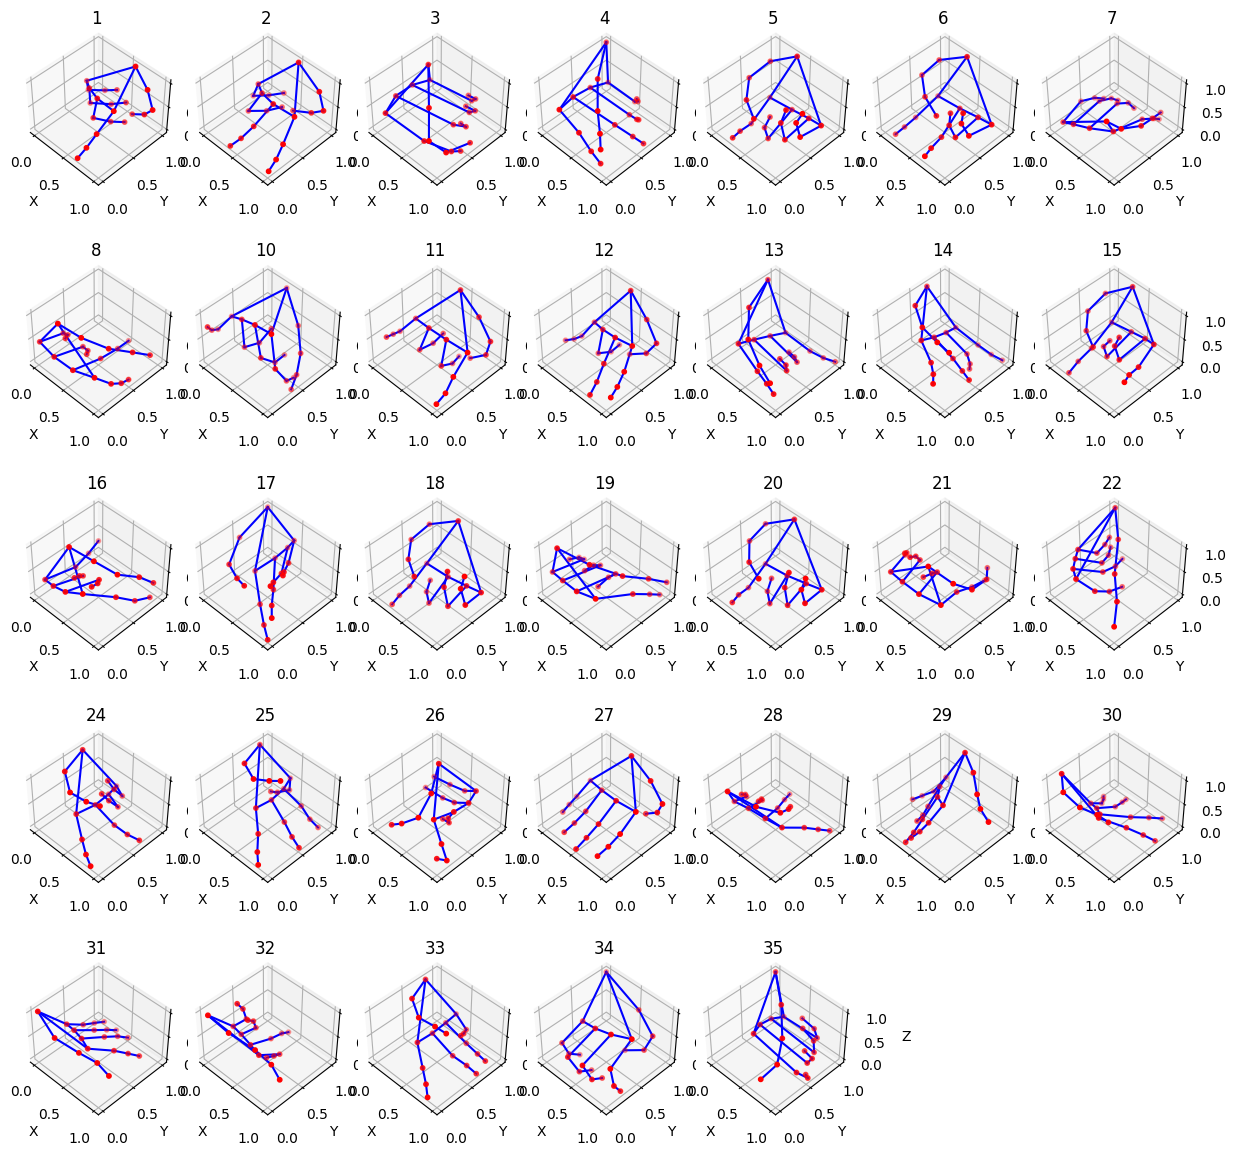

In [5]:
video_path = 'fingerspelling korean.mp4'
set_path = './dataset/korean/samples/vowels/'
processed_path = './dataset/korean/vowels_processed/'

processor = HandLandmark()



"""폴더에 있는 전체 이미지 Mediapipe로 Hand LandMark 생성"""
# processor.process_images(set_path, processed_path)


"""csv 파일을 읽어서 3D 그래프로 그려줌 -> 약간 잘 뽑혔는지 확인 용"""
csv_dir = os.path.join(processed_path, 'csv')
processor.plot_csv_landmarks(csv_dir)


"""처리가 안된 이미지가 있으면 직접 처리해줘야 함"""
image_num = 5
image_path = os.path.join(set_path, f'{image_num}.png')
# processor.process_image_data(image_path, processed_path)


In [6]:
csv_dir = os.path.join(processed_path, 'csv')
labels = sorted([os.path.splitext(filename)[0] for filename in os.listdir(csv_dir) if filename.endswith(".csv")], key=int)


print(f"labels: {labels}")
xyz = []
for label in labels:
    csv_path = os.path.join(csv_dir, f"{label}.csv")
    print(csv_path)
    with open(csv_path, mode='r') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)
        x, y, z = zip(*[(float(row[1]), float(row[2]), float(row[3])) for row in reader])
        x , y , z = np.array(x), np.array(y), np.array(z)
        xyz.append([x, y, z])
        # for connection in mp.solutions.hands.HAND_CONNECTIONS:
        #     x_pair = [x[connection[0]], x[connection[1]]]
        #     y_pair = [y[connection[0]], y[connection[1]]]
        #     z_pair = [z[connection[0]], z[connection[1]]]
            

labels: ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
./dataset/korean/vowels_processed/csv/1.csv
./dataset/korean/vowels_processed/csv/2.csv
./dataset/korean/vowels_processed/csv/3.csv
./dataset/korean/vowels_processed/csv/4.csv
./dataset/korean/vowels_processed/csv/5.csv
./dataset/korean/vowels_processed/csv/6.csv
./dataset/korean/vowels_processed/csv/7.csv
./dataset/korean/vowels_processed/csv/8.csv
./dataset/korean/vowels_processed/csv/10.csv
./dataset/korean/vowels_processed/csv/11.csv
./dataset/korean/vowels_processed/csv/12.csv
./dataset/korean/vowels_processed/csv/13.csv
./dataset/korean/vowels_processed/csv/14.csv
./dataset/korean/vowels_processed/csv/15.csv
./dataset/korean/vowels_processed/csv/16.csv
./dataset/korean/vowels_processed/csv/17.csv
./dataset/korean/vowels_processed/csv/18.csv
./dataset/korean/vowels_processed/csv/19.csv

In [7]:
len(xyz) # 23, 9 없음

33

In [8]:
xyz[0][0] # Number: 0

array([0.60187203, 0.84181028, 1.        , 0.87565665, 0.65525822,
       0.71528028, 0.69314   , 0.67846195, 0.66290527, 0.40194683,
       0.38464032, 0.51644155, 0.63730767, 0.1699008 , 0.15782072,
       0.37079363, 0.53327886, 0.00112942, 0.        , 0.18705422,
       0.34238712])

In [9]:
np.array(xyz).shape

(33, 3, 21)

# PreProcess

In [14]:
# Augmentation
# 1. Rotation

def rotate(xyz, rotation_matrix):
    """
    Input : (3,21) x,y,z * 21
    """
    if np.array(xyz).shape == (3,21):
        for i in range(21):
            xyz[:,i] = np.dot(rotation_matrix, xyz[:,i])
        return xyz
    else:
        return None


# 2. Axis-Scaling

def scale(xyz, axis, scale_factor):
    """
    Input : (3,21) x,y,z * 21
    """
    if np.array(xyz).shape == (3,21):
        for i in range(21):
            xyz[axis,i] = xyz[axis,i] * scale_factor
        return xyz
    else:
        return None
    


In [30]:
# plt.figure(figsize=(12, 12))
# ax = plt.axes(projection='3d')
# for connection in mp.solutions.hands.HAND_CONNECTIONS:
#     x_pair = [x[connection[0]], x[connection[1]]]
#     y_pair = [y[connection[0]], y[connection[1]]]
#     z_pair = [z[connection[0]], z[connection[1]]]
#     ax.plot(x_pair, y_pair, z_pair, color='b')
#     ax.scatter(x, y, z, s=10, c='r')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.view_init(elev=45., azim=-45.)

#### Preprocess : Rotation

X Axis Rotation 30 degree

(3, 21)


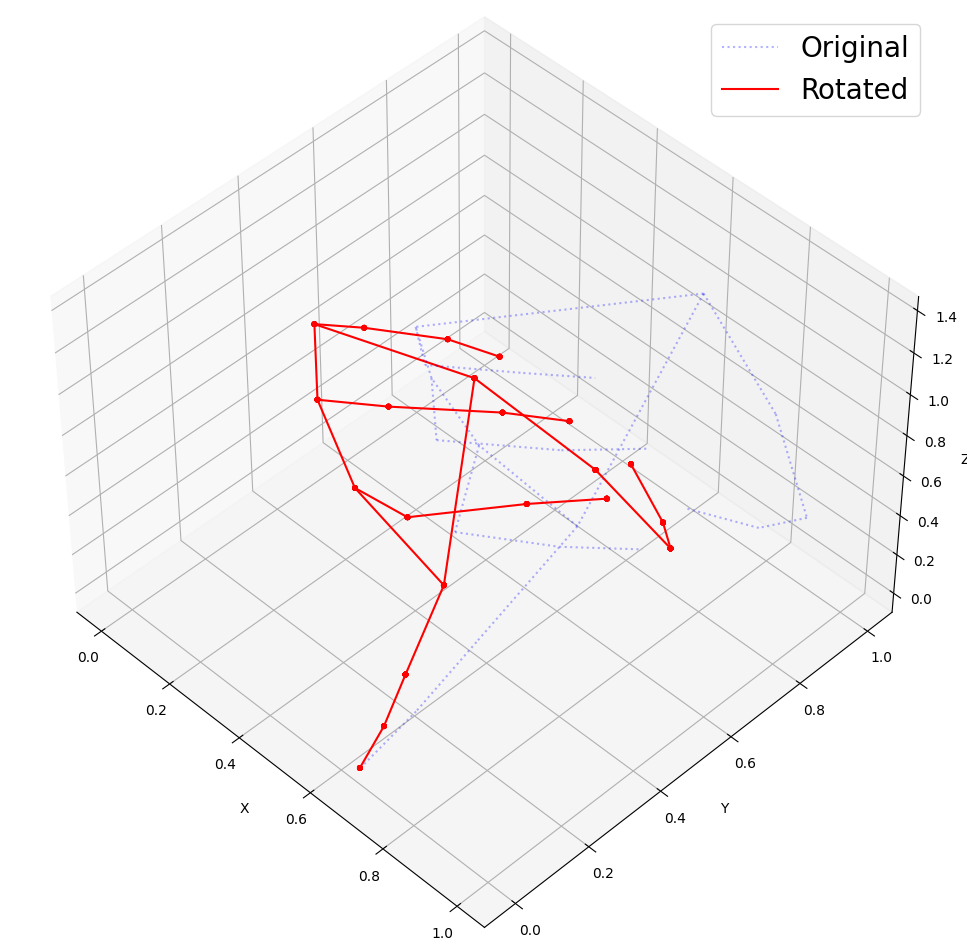

In [59]:
from scipy.spatial.transform import Rotation as R
sample_xyz = np.array(xyz[0])
print(sample_xyz.shape)
rotated_xyz = rotate(sample_xyz, R.from_euler('x', 30, degrees=True).as_matrix())

# Rotation Visualization
plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
for connection in mp.solutions.hands.HAND_CONNECTIONS:
    x_pair = [x[connection[0]], x[connection[1]]]
    y_pair = [y[connection[0]], y[connection[1]]]
    z_pair = [z[connection[0]], z[connection[1]]]

    x_rotated_pair = [rotated_xyz[0][connection[0]], rotated_xyz[0][connection[1]]]
    y_rotated_pair = [rotated_xyz[1][connection[0]], rotated_xyz[1][connection[1]]]
    z_rotated_pair = [rotated_xyz[2][connection[0]], rotated_xyz[2][connection[1]]]

    ax.plot(x_pair, y_pair, z_pair, color='b', alpha=0.3, linestyle=':')
    ax.plot(x_rotated_pair, y_rotated_pair, z_rotated_pair, color='r')
    ax.scatter(rotated_xyz[0], rotated_xyz[1], rotated_xyz[2], s=10, c='r')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(['Original', 'Rotated'],fontsize=20)
    ax.view_init(elev=45., azim=-45.)

Y Axis Rotation 30 degree

(3, 21)


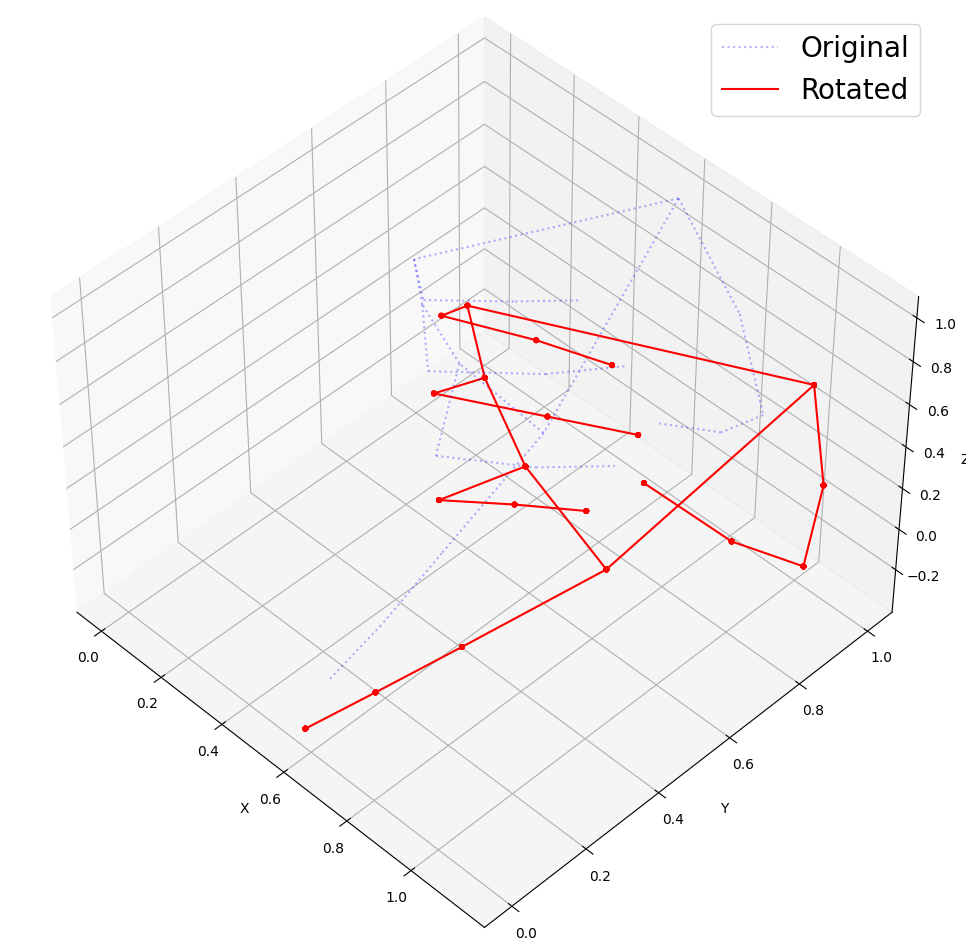

In [60]:
from scipy.spatial.transform import Rotation as R
sample_xyz = np.array(xyz[0])
print(sample_xyz.shape)
rotated_xyz = rotate(sample_xyz, R.from_euler('y', 30, degrees=True).as_matrix())

# Rotation Visualization
plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
for connection in mp.solutions.hands.HAND_CONNECTIONS:
    x_pair = [x[connection[0]], x[connection[1]]]
    y_pair = [y[connection[0]], y[connection[1]]]
    z_pair = [z[connection[0]], z[connection[1]]]

    x_rotated_pair = [rotated_xyz[0][connection[0]], rotated_xyz[0][connection[1]]]
    y_rotated_pair = [rotated_xyz[1][connection[0]], rotated_xyz[1][connection[1]]]
    z_rotated_pair = [rotated_xyz[2][connection[0]], rotated_xyz[2][connection[1]]]

    ax.plot(x_pair, y_pair, z_pair, color='b', alpha=0.3, linestyle=':')
    ax.plot(x_rotated_pair, y_rotated_pair, z_rotated_pair, color='r')
    ax.scatter(rotated_xyz[0], rotated_xyz[1], rotated_xyz[2], s=10, c='r')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(['Original', 'Rotated'],fontsize=20)
    ax.view_init(elev=45., azim=-45.)

Z Axis Rotation 30 degree

(3, 21)


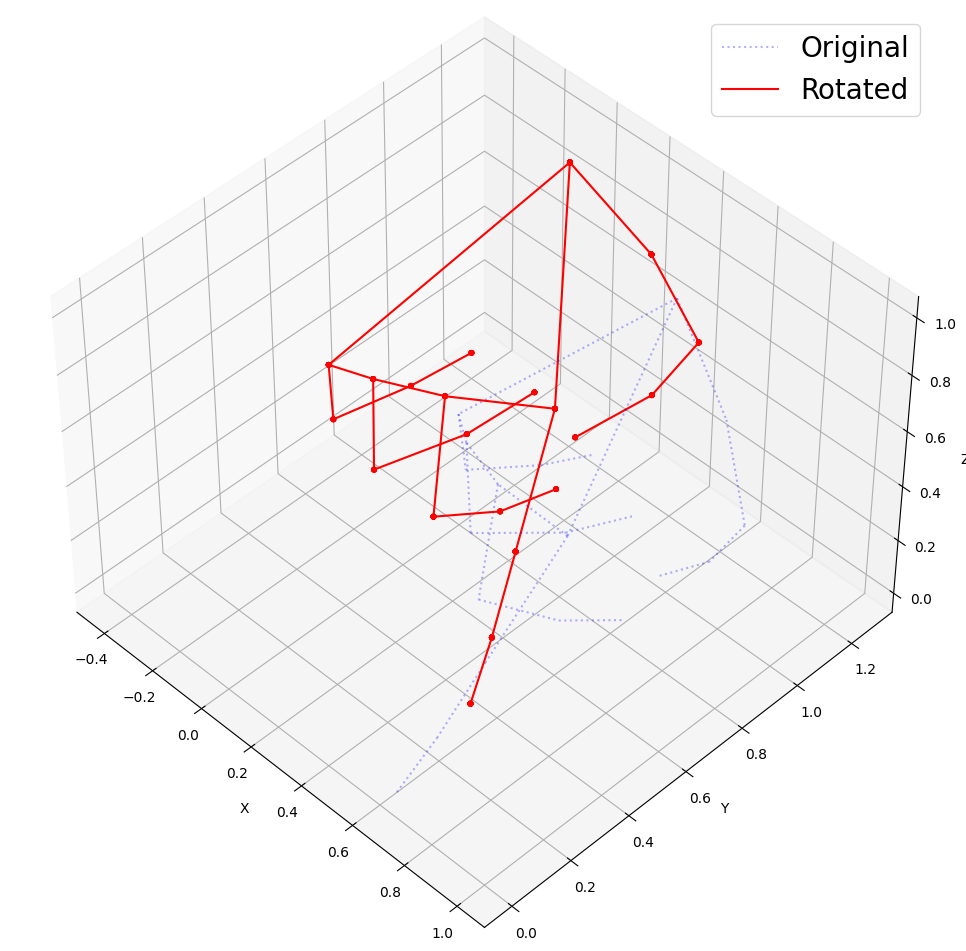

In [63]:
from scipy.spatial.transform import Rotation as R
sample_xyz = np.array(xyz[0])
print(sample_xyz.shape)
rotated_xyz = rotate(sample_xyz, R.from_euler('z', 30, degrees=True).as_matrix())

# Rotation Visualization
plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
for connection in mp.solutions.hands.HAND_CONNECTIONS:
    x_pair = [x[connection[0]], x[connection[1]]]
    y_pair = [y[connection[0]], y[connection[1]]]
    z_pair = [z[connection[0]], z[connection[1]]]

    x_rotated_pair = [rotated_xyz[0][connection[0]], rotated_xyz[0][connection[1]]]
    y_rotated_pair = [rotated_xyz[1][connection[0]], rotated_xyz[1][connection[1]]]
    z_rotated_pair = [rotated_xyz[2][connection[0]], rotated_xyz[2][connection[1]]]

    ax.plot(x_pair, y_pair, z_pair, color='b', alpha=0.3, linestyle=':')
    ax.plot(x_rotated_pair, y_rotated_pair, z_rotated_pair, color='r')
    ax.scatter(rotated_xyz[0], rotated_xyz[1], rotated_xyz[2], s=10, c='r')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(['Original', 'Rotated'],fontsize=20)
    
    ax.view_init(elev=45., azim=-45.)

#### Preprocess : Scaling

X

(3, 21)


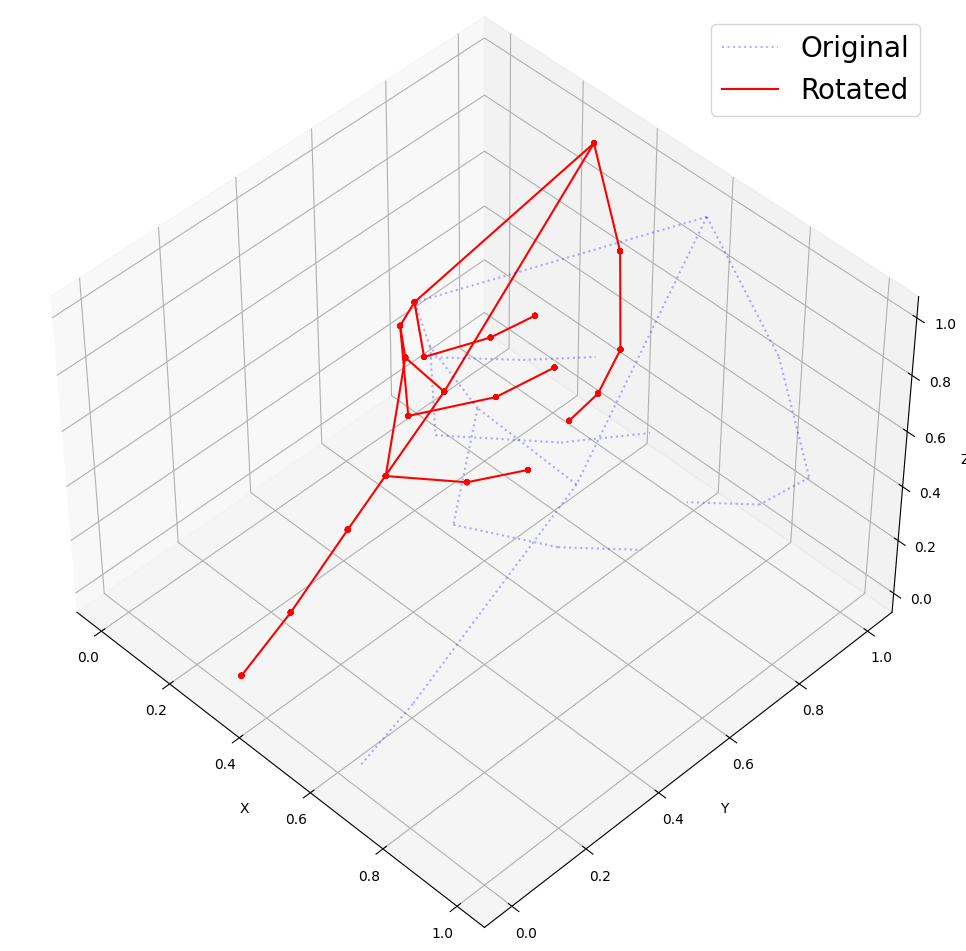

In [64]:
from scipy.spatial.transform import Rotation as R
sample_xyz = np.array(xyz[0])
print(sample_xyz.shape)
scaled_xyz = scale(sample_xyz, 0, 0.5)

# Rotation Visualization
plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
for connection in mp.solutions.hands.HAND_CONNECTIONS:
    x_pair = [x[connection[0]], x[connection[1]]]
    y_pair = [y[connection[0]], y[connection[1]]]
    z_pair = [z[connection[0]], z[connection[1]]]

    x_rotated_pair = [scaled_xyz[0][connection[0]], scaled_xyz[0][connection[1]]]
    y_rotated_pair = [scaled_xyz[1][connection[0]], scaled_xyz[1][connection[1]]]
    z_rotated_pair = [scaled_xyz[2][connection[0]], scaled_xyz[2][connection[1]]]

    ax.plot(x_pair, y_pair, z_pair, color='b', alpha=0.3, linestyle=':')
    ax.plot(x_rotated_pair, y_rotated_pair, z_rotated_pair, color='r')
    ax.scatter(scaled_xyz[0], scaled_xyz[1], scaled_xyz[2], s=10, c='r')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(['Original', 'Rotated'],fontsize=20)
    ax.view_init(elev=45., azim=-45.)

Y

(3, 21)


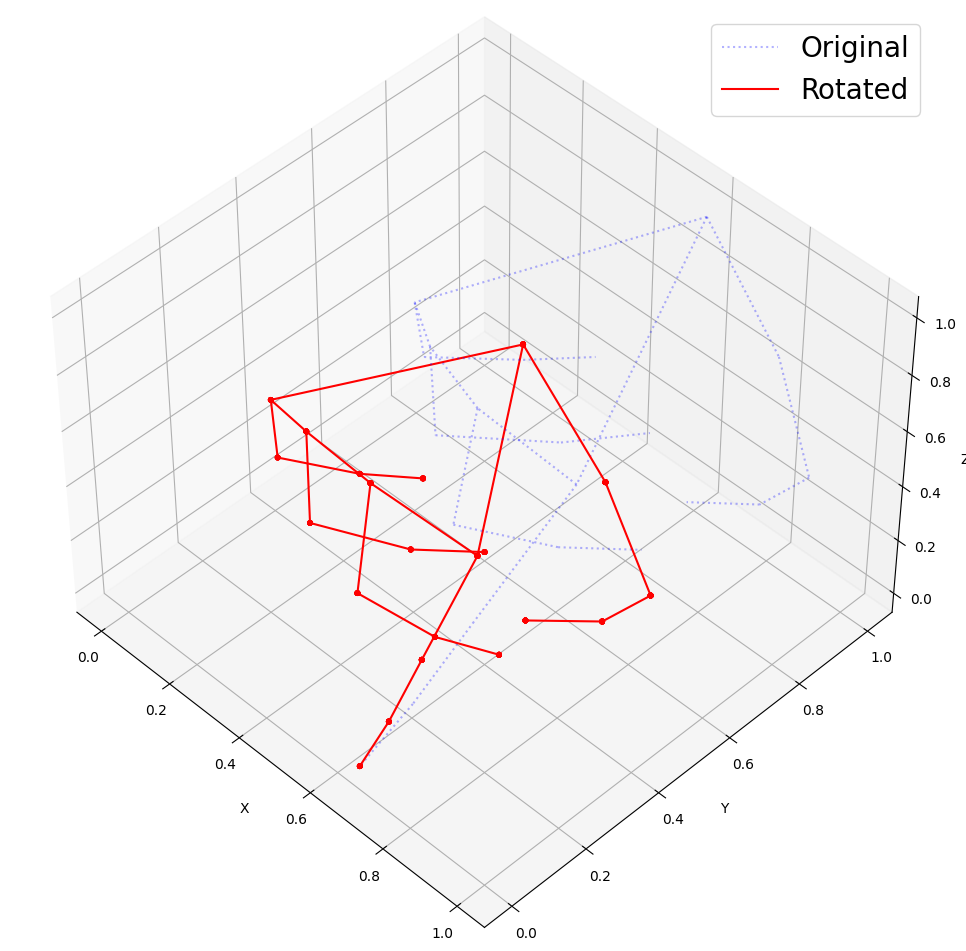

In [65]:
from scipy.spatial.transform import Rotation as R
sample_xyz = np.array(xyz[0])
print(sample_xyz.shape)
scaled_xyz = scale(sample_xyz, 1, 0.5)

# Rotation Visualization
plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
for connection in mp.solutions.hands.HAND_CONNECTIONS:
    x_pair = [x[connection[0]], x[connection[1]]]
    y_pair = [y[connection[0]], y[connection[1]]]
    z_pair = [z[connection[0]], z[connection[1]]]

    x_rotated_pair = [scaled_xyz[0][connection[0]], scaled_xyz[0][connection[1]]]
    y_rotated_pair = [scaled_xyz[1][connection[0]], scaled_xyz[1][connection[1]]]
    z_rotated_pair = [scaled_xyz[2][connection[0]], scaled_xyz[2][connection[1]]]

    ax.plot(x_pair, y_pair, z_pair, color='b', alpha=0.3, linestyle=':')
    ax.plot(x_rotated_pair, y_rotated_pair, z_rotated_pair, color='r')
    ax.scatter(scaled_xyz[0], scaled_xyz[1], scaled_xyz[2], s=10, c='r')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(['Original', 'Rotated'],fontsize=20)
    ax.view_init(elev=45., azim=-45.)

Z

(3, 21)


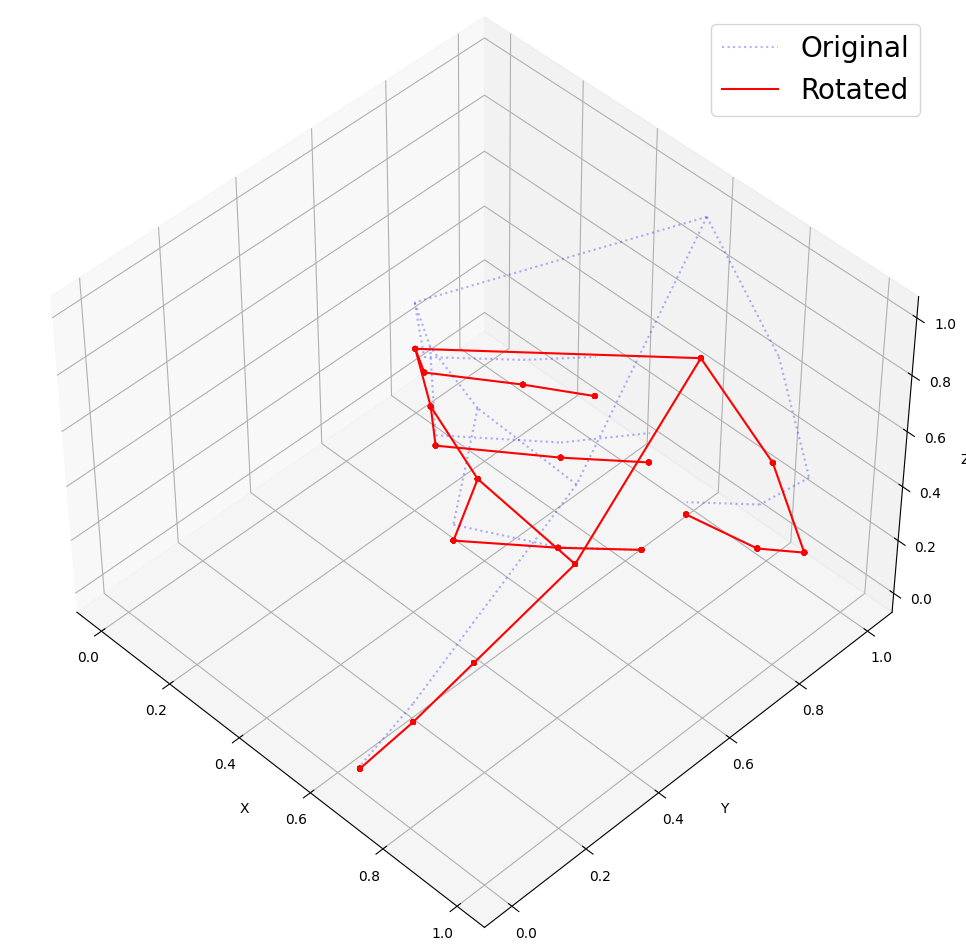

In [66]:
from scipy.spatial.transform import Rotation as R
sample_xyz = np.array(xyz[0])
print(sample_xyz.shape)
scaled_xyz = scale(sample_xyz, 2, 0.5)

# Rotation Visualization
plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
for connection in mp.solutions.hands.HAND_CONNECTIONS:
    x_pair = [x[connection[0]], x[connection[1]]]
    y_pair = [y[connection[0]], y[connection[1]]]
    z_pair = [z[connection[0]], z[connection[1]]]

    x_rotated_pair = [scaled_xyz[0][connection[0]], scaled_xyz[0][connection[1]]]
    y_rotated_pair = [scaled_xyz[1][connection[0]], scaled_xyz[1][connection[1]]]
    z_rotated_pair = [scaled_xyz[2][connection[0]], scaled_xyz[2][connection[1]]]

    ax.plot(x_pair, y_pair, z_pair, color='b', alpha=0.3, linestyle=':')
    ax.plot(x_rotated_pair, y_rotated_pair, z_rotated_pair, color='r')
    ax.scatter(scaled_xyz[0], scaled_xyz[1], scaled_xyz[2], s=10, c='r')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(['Original', 'Rotated'],fontsize=20)
    ax.view_init(elev=45., azim=-45.)